# Gradient reversal for fairness on COMPAS
In this notebook, I'll tackle three things:

- Train a plain old neural network on the COMPAS dataset. Since COMPAS is a linear regression model, we should be able to mimic it as good as possible with a NN, with the data we have.
- Train another NN, but this time with a second output to reverse the gradients on the protected attribute `race`.
- Apply transfer learning on the regular NN to try to see bias against the protected attribute `race`.

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from plot_confusion_matrix import plot_confusion_matrix

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix

from keras import losses
from keras.layers import Input, Embedding, GRU, Dense, Masking, Bidirectional, concatenate, Dropout,Flatten
from keras.models import Model
from keras.engine import Layer
import keras.backend as K

import tensorflow as tf

Using TensorFlow backend.


# Data analysis
Let's start by a simple data analysis and visualization.

In [2]:
df = pd.read_csv(os.path.join("..", "data", "csv", "scikit", "compas_recidive_two_years_sanitize_age_category_jail_time_decile_score.csv"))
df.head()

,sex,age_cat,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_jail_time (days),date_dif_in_jail,c_charge_degree,is_recid,decile_score,score_text,two_year_recid
0,Male,Greater than 45,Other,0,0,0,0,-1,2013-08-13 06:03:42,2013-08-14 05:41:20,0.984468,1,F,0,1,Low,0
1,Male,25 - 45,African-American,0,0,0,0,-1,2013-01-26 03:45:27,2013-02-05 05:36:53,10.077384,10,F,1,3,Low,1
2,Male,Less than 25,African-American,0,0,1,4,-1,2013-04-13 04:58:34,2013-04-14 07:02:04,1.085764,1,F,1,4,Low,1
3,Male,25 - 45,Other,0,0,0,0,0,2013-11-30 04:50:18,2013-12-01 12:28:56,1.318495,1,M,0,1,Low,0
4,Male,25 - 45,Caucasian,0,0,0,14,-1,2014-02-18 05:08:24,2014-02-24 12:18:30,6.298681,6,F,1,6,Medium,1


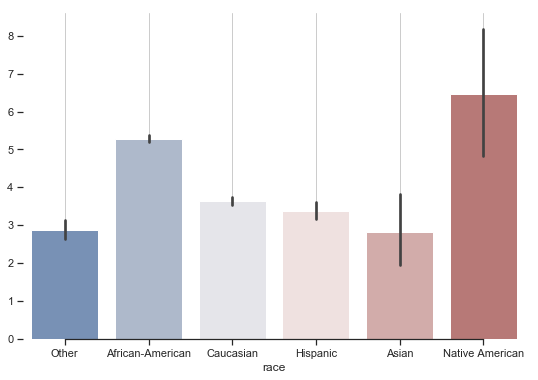

In [3]:
sns.set(style="ticks")

f, ax = plt.subplots(figsize=(9, 6))

sns.barplot(x=df["race"], y=df["decile_score"], palette="vlag")

ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

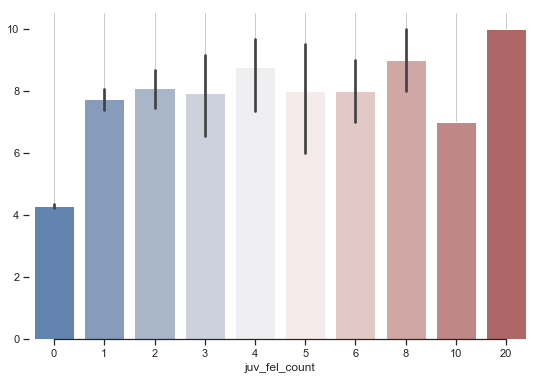

In [4]:
sns.set(style="ticks")

f, ax = plt.subplots(figsize=(9, 6))

sns.barplot(x=df["juv_fel_count"], y=df["decile_score"], palette="vlag")

ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

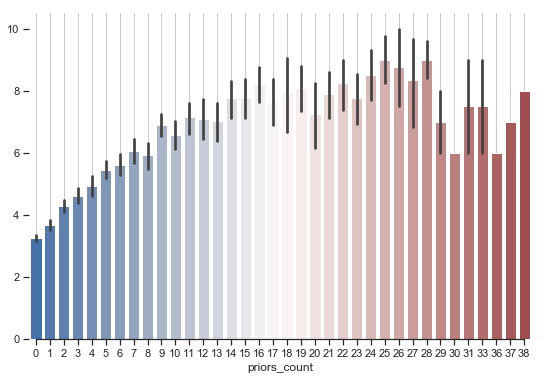

In [5]:
sns.set(style="ticks")

f, ax = plt.subplots(figsize=(9, 6))

sns.barplot(x=df["priors_count"], y=df["decile_score"], palette="vlag")

ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

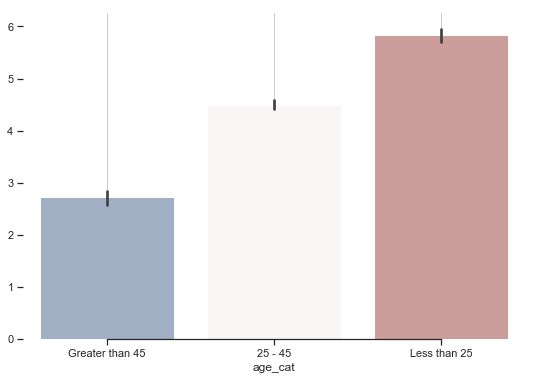

In [6]:
sns.set(style="ticks")

f, ax = plt.subplots(figsize=(9, 6))

sns.barplot(x=df["age_cat"], y=df["decile_score"], palette="vlag")

ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

Most papers discussing COMPAS only look into the protected attibute `race` with the values `Caucasian` and `African-American`. This makes sense, since there's a lot less data on other races. So we'll do the same.

In [7]:
df_binary = df[(df["race"] == "Caucasian") | (df["race"] == "African-American")]

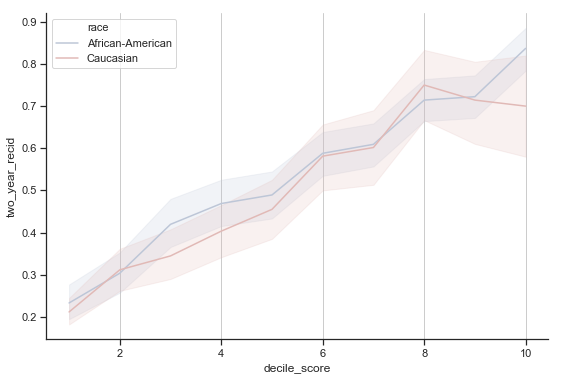

In [8]:
f, ax = plt.subplots(figsize=(9, 6))

sns.lineplot(x="decile_score", y="two_year_recid",
             hue="race",
             data=df_binary, palette="vlag")

ax.xaxis.grid(True)
sns.despine(trim=False, left=False)

From what I see here, the COMPAS system does quite a good job to assign a meaningful score for the chance of recedivism in 2 years. And for both African-Americans and Caucasians, this score behaves similar.

# Naive classifier

In [9]:
del df_binary['c_jail_in']
del df_binary['c_jail_out']

##separated class from the rests of the features
Y = df_binary[['decile_score', 'two_year_recid', 'race', 'score_text']]
del df_binary['decile_score']
del df_binary['two_year_recid']
del df_binary['score_text']


S = df_binary['race']

In [10]:
df_binary.head()

,sex,age_cat,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_time (days),date_dif_in_jail,c_charge_degree,is_recid
1,Male,25 - 45,African-American,0,0,0,0,-1,10.077384,10,F,1
2,Male,Less than 25,African-American,0,0,1,4,-1,1.085764,1,F,1
4,Male,25 - 45,Caucasian,0,0,0,14,-1,6.298681,6,F,1
6,Female,25 - 45,Caucasian,0,0,0,0,-1,2.953611,3,M,0
7,Male,25 - 45,Caucasian,0,0,0,0,-1,1.080451,1,F,0


In [11]:
encod = preprocessing.OrdinalEncoder()
encod.fit(df_binary)
X = encod.transform(df_binary)
X = pd.DataFrame(X)
X.columns = df_binary.columns
X.head()

,sex,age_cat,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_time (days),date_dif_in_jail,c_charge_degree,is_recid
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0,4127.0,10.0,0.0,1.0
1,1.0,2.0,0.0,0.0,0.0,1.0,4.0,29.0,2204.0,1.0,0.0,1.0
2,1.0,0.0,1.0,0.0,0.0,0.0,14.0,29.0,3920.0,6.0,0.0,1.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,29.0,3503.0,3.0,1.0,0.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,29.0,2184.0,1.0,0.0,0.0


In [12]:
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.3, random_state=42)

In [13]:
print(X_train.shape)
print(len(Y_train))

(3694, 12)
3694


In [14]:
input = Input(batch_shape=(None, X_train.shape[1]), name='input')

x = Dense(64, activation="relu")(input)
x = Dropout(0.1)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.1)(x)
output = Dense(1, activation="linear", name="output")(x)

model = Model(inputs=[input], outputs=[output])

model.compile(optimizer='adadelta',
              loss=losses.MSE,
              metrics=['mse'])

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 12)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                832       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
__________

In [16]:
history = model.fit(
            {'input': X_train},
            {'output': Y_train['decile_score']},
            epochs=1500,
            batch_size=64,
            verbose=0,
            validation_split=0.1,
            class_weight=[1, 1])

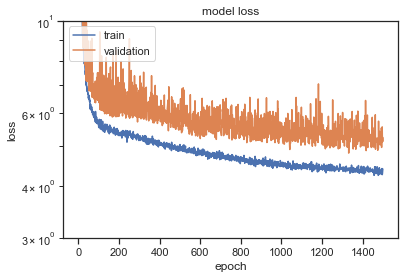

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale("log")
plt.ylim(3,10)
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [18]:
Y_pred = model.predict(X_test)
Y_pred

array([[3.0018654],
       [3.5807352],
       [5.1482296],
       ...,
       [2.9831111],
       [3.00122  ],
       [4.617559 ]], dtype=float32)

In [19]:
prediction = X_test.copy()
prediction['prediction']= Y_pred
prediction['true'] = Y_test['decile_score'].values
prediction['two_year_recid'] = Y_test['two_year_recid'].values

prediction.head()

,sex,age_cat,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_time (days),date_dif_in_jail,c_charge_degree,is_recid,prediction,true,two_year_recid
8,0.0,1.0,1.0,0.0,0.0,0.0,1.0,10.0,4268.0,14.0,0.0,1.0,3.001865,1,1
4246,1.0,0.0,0.0,0.0,0.0,0.0,2.0,29.0,1110.0,1.0,1.0,1.0,3.580735,3,0
544,0.0,2.0,0.0,0.0,0.0,0.0,0.0,29.0,1116.0,1.0,0.0,1.0,5.148230,7,0
1780,1.0,0.0,1.0,0.0,0.0,0.0,1.0,29.0,825.0,1.0,0.0,1.0,3.129840,2,1
3940,1.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0,2787.0,1.0,0.0,1.0,3.592918,2,1


In [20]:
type(Y_pred)

numpy.ndarray

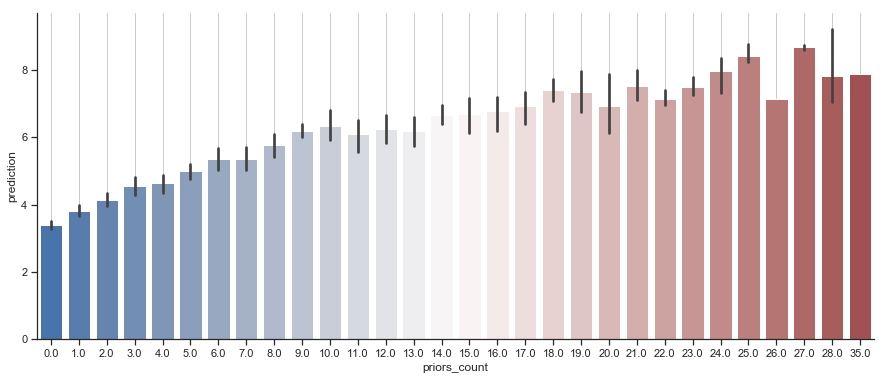

In [21]:
f, ax = plt.subplots(figsize=(15, 6))

sns.barplot(x="priors_count", y="prediction", data=prediction, palette="vlag")

ax.xaxis.grid(True)
sns.despine(trim=False, left=False)

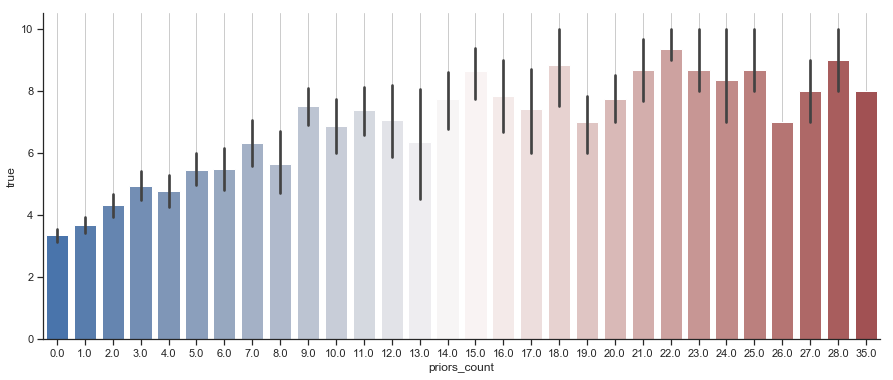

In [22]:
f, ax = plt.subplots(figsize=(15, 6))

sns.barplot(x="priors_count", y="true", data=prediction, palette="vlag")

ax.xaxis.grid(True)
sns.despine(trim=False, left=False)

In [23]:
prediction['dec_pred'] = prediction['prediction'].astype(np.int)

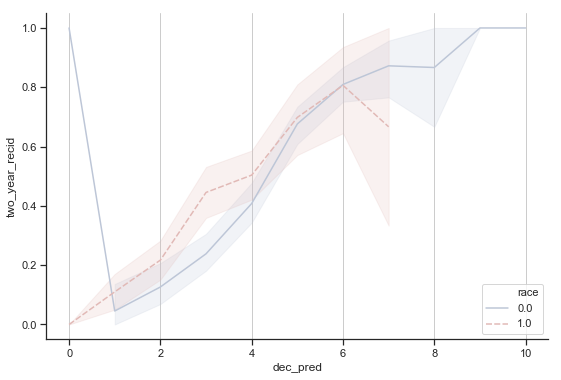

In [24]:
f, ax = plt.subplots(figsize=(9, 6))

sns.lineplot(x="dec_pred", y="two_year_recid",
             hue="race", style="race",
             data=prediction, palette="vlag")

ax.xaxis.grid(True)
sns.despine(trim=False, left=False)

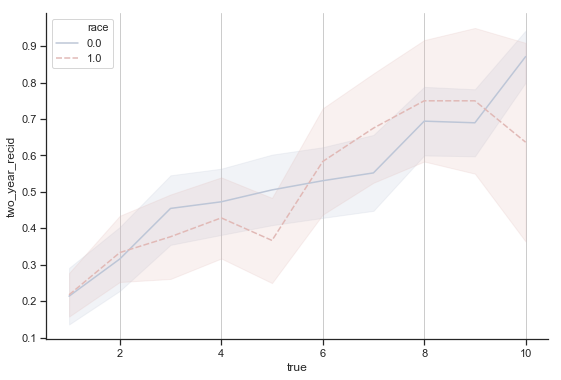

In [25]:
f, ax = plt.subplots(figsize=(9, 6))

sns.lineplot(x="true", y="two_year_recid",
             hue="race", style="race",
             data=prediction, palette="vlag")

ax.xaxis.grid(True)
sns.despine(trim=False, left=False)

# Freeze layers of standard model to do some quick-and-dirty transfer learning

In [26]:
for layer in model.layers:
    if layer.name.startswith("dense_"):
        layer.trainable = False

In [27]:
output_protected = Dense(2, activation="softmax", name="output_protected")(x)


naive_model = Model(inputs=[input], outputs=[output_protected])

naive_model.compile(optimizer='adam',
              loss={'output_protected': losses.binary_crossentropy},
              metrics={ 'output_protected': 'acc'})

In [28]:
naive_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 12)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                832       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
__________

In [29]:
history = naive_model.fit(
            {'input': X_train},
            {'output_protected': pd.get_dummies(Y_train['race'])},
            epochs=100,
            batch_size=64,
            verbose=0,
            validation_split=0.1,
            class_weight=[1, 1])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:1479: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_ylim(*args, **kwargs)


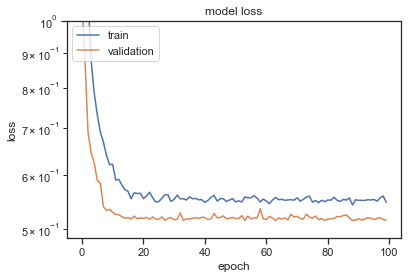

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale("log")
plt.ylim(0,1)
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [31]:
Y_pred = naive_model.predict(X_test)

# Reverse gradient regressor/classifier
Instead of naively training on all data, this network has an extra output corresponding to the protected attribute `race`. By reversing the gradients for that output, we essentially train the model to ignore all correlations with this.

In [32]:
def reverse_gradient(X, hp_lambda):
    '''Flips the sign of the incoming gradient during training.'''
    try:
        reverse_gradient.num_calls += 1
    except AttributeError:
        reverse_gradient.num_calls = 1

    grad_name = "GradientReversal%d" % reverse_gradient.num_calls

    @tf.RegisterGradient(grad_name)
    def _flip_gradients(op, grad):
        return [tf.negative(grad) * hp_lambda]

    g = K.get_session().graph
    with g.gradient_override_map({'Identity': grad_name}):
        y = tf.identity(X)

    return y

class GradientReversal(Layer):
    '''Flip the sign of gradient during training.'''
    def __init__(self, hp_lambda, **kwargs):
        super(GradientReversal, self).__init__(**kwargs)
        self.supports_masking = False
        self.hp_lambda = hp_lambda

    def build(self, input_shape):
        self.trainable_weights = []

    def call(self, x, mask=None):
        return reverse_gradient(x, self.hp_lambda)

    def get_output_shape_for(self, input_shape):
        return input_shape

    def get_config(self):
        config = {'hp_lambda': self.hp_lambda}
        base_config = super(GradientReversal, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [33]:
input = Input(batch_shape=(None, X_train.shape[1]), name='input')

x = Dense(64, activation="relu")(input)
x = Dropout(0.1)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.1)(x)
output = Dense(1, activation="linear", name="output")(x)

Flip = GradientReversal(10)
dann_in = Flip(x)
dann_out = Dense(2)(dann_in)

output2 = Dense(2, activation="softmax", name="output2")(dann_out)


debiased_model = Model(inputs=[input], outputs=[output, output2])

debiased_model.compile(optimizer='adam',
              loss={'output': losses.MSE, 'output2': losses.binary_crossentropy},
              metrics={'output': losses.MSE, 'output2': 'acc'})

In [34]:
debiased_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 12)           0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 64)           832         input[0][0]                      
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 64)           0           dense_4[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 64)           4160        dropout_4[0][0]                  
__________________________________________________________________________________________________
dropout_5 

In [35]:
history = debiased_model.fit(
            {'input': X_train},
            {'output': Y_train['decile_score'], 'output2': pd.get_dummies(Y_train['race'])},
            epochs=5000,
            batch_size=64,
            verbose=0,
            validation_split=0.1,
            class_weight=[1, 1])

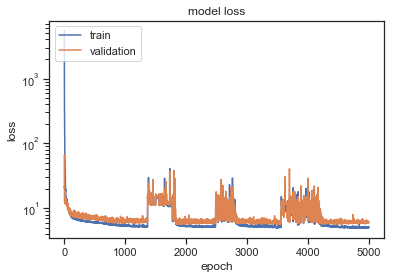

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale("log")
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Note: _I don't know why there are these stability issues. This is not exactly a GAN setup, but the root cause might be related..._

In [37]:
Y_pred_debiassed = debiased_model.predict(X_test)
Y_pred_debiassed

[array([[3.952733 ],
        [3.342334 ],
        [5.4109173],
        ...,
        [2.878449 ],
        [2.9775102],
        [4.495996 ]], dtype=float32), array([[0.6218724 , 0.3781276 ],
        [0.5587427 , 0.44125724],
        [0.5647828 , 0.4352172 ],
        ...,
        [0.5093893 , 0.49061078],
        [0.5123235 , 0.4876765 ],
        [0.5848161 , 0.4151839 ]], dtype=float32)]

In [38]:
prediction['debiased_prediction']= Y_pred_debiassed[0]
#prediction['true'] = Y_test['decile_score'].values
prediction['score_text'] = Y_test['score_text'].values
#prediction['two_year_recid'] = Y_test['two_year_recid'].values

prediction.head()

,sex,age_cat,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_time (days),date_dif_in_jail,c_charge_degree,is_recid,prediction,true,two_year_recid,dec_pred,debiased_prediction,score_text
8,0.0,1.0,1.0,0.0,0.0,0.0,1.0,10.0,4268.0,14.0,0.0,1.0,3.001865,1,1,3,3.952733,Low
4246,1.0,0.0,0.0,0.0,0.0,0.0,2.0,29.0,1110.0,1.0,1.0,1.0,3.580735,3,0,3,3.342334,Low
544,0.0,2.0,0.0,0.0,0.0,0.0,0.0,29.0,1116.0,1.0,0.0,1.0,5.148230,7,0,5,5.410917,Medium
1780,1.0,0.0,1.0,0.0,0.0,0.0,1.0,29.0,825.0,1.0,0.0,1.0,3.129840,2,1,3,3.944808,Low
3940,1.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0,2787.0,1.0,0.0,1.0,3.592918,2,1,3,3.125460,Low


In [39]:
type(Y_pred)

numpy.ndarray

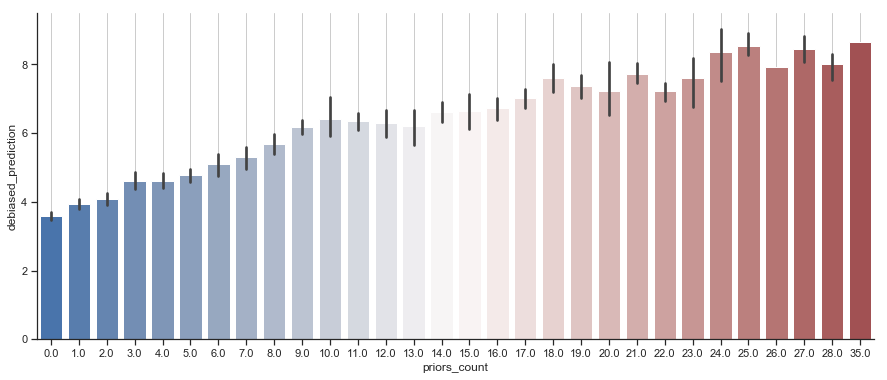

In [40]:
f, ax = plt.subplots(figsize=(15, 6))

sns.barplot(x="priors_count", y="debiased_prediction", data=prediction, palette="vlag")

ax.xaxis.grid(True)
sns.despine(trim=False, left=False)

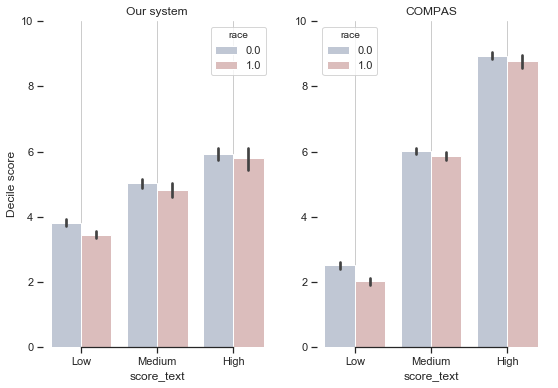

In [41]:
sns.set(style="ticks")

f, (ax1, ax2) = plt.subplots(1,2,figsize=(9, 6))

sns.barplot(x="score_text", y="debiased_prediction", hue="race", data=prediction, palette="vlag", ax=ax1, order=["Low", "Medium", "High"])

sns.barplot(x="score_text", y="true", hue="race", data=prediction, palette="vlag", ax=ax2, order=["Low", "Medium", "High"])

ax1.xaxis.grid(True)
ax1.set(ylabel="Decile score")
ax1.set(ylim=(0,10))
ax1.set(title="Our system")
ax2.xaxis.grid(True)
ax2.set(ylabel="")
ax2.set(ylim=(0,10))
ax2.set(title="COMPAS")
sns.despine(trim=True, left=True)

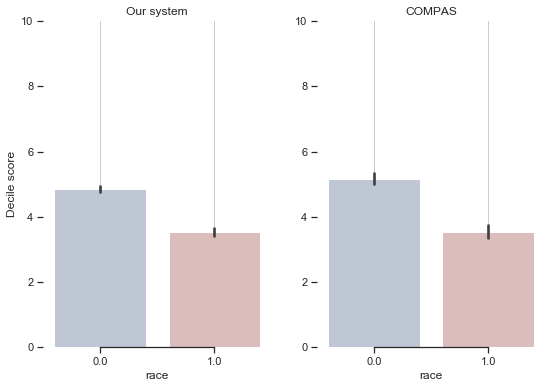

In [42]:
sns.set(style="ticks")

f, (ax1, ax2) = plt.subplots(1,2,figsize=(9, 6))

sns.barplot(x="race", y="prediction", data=prediction, palette="vlag", ax=ax1)

sns.barplot(x="race", y="true", data=prediction, palette="vlag", ax=ax2)

ax1.xaxis.grid(True)
ax1.set(ylabel="Decile score")
ax1.set(ylim=(0,10))
ax1.set(title="Our system")
ax2.xaxis.grid(True)
ax2.set(ylabel="")
ax2.set(ylim=(0,10))
ax2.set(title="COMPAS")
sns.despine(trim=True, left=True)

In [43]:
Y_pred_debiassed[1][:,1]

array([0.3781276 , 0.44125724, 0.4352172 , ..., 0.49061078, 0.4876765 ,
       0.4151839 ], dtype=float32)

In [44]:
prediction['dec_pred'] = prediction['debiased_prediction'].astype(np.int)

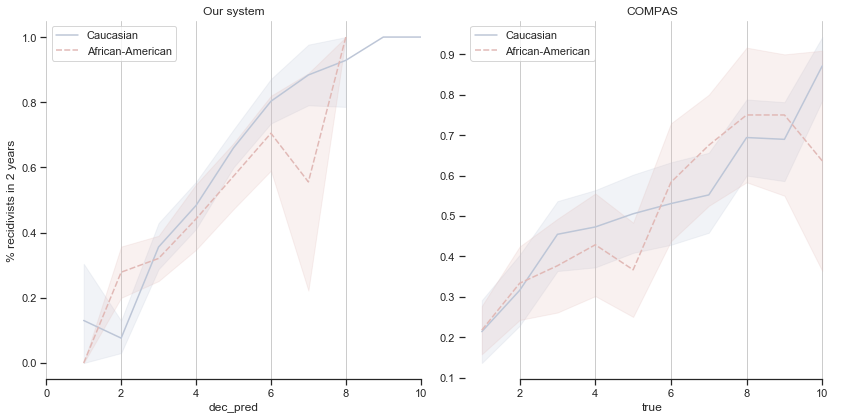

In [45]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(12, 6), dpi=72)

sns.lineplot(x="dec_pred", y="two_year_recid",
             hue="race", style="race",
             data=prediction, palette="vlag", ax=ax1) 

sns.lineplot(x="true", y="two_year_recid",
             hue="race", style="race",
             data=prediction, palette="vlag")

ax1.xaxis.grid(True)
ax1.set(ylabel="% recidivists in 2 years")
ax1.set(title="Our system")
ax1.set(xlim=(0,10))
ax1.legend(['Caucasian', 'African-American'], loc="upper left")
ax2.xaxis.grid(True)
ax2.set(ylabel="")
ax2.set(title="COMPAS")
sns.despine(trim=True, left=True)
plt.tight_layout()
ax2.legend(['Caucasian', 'African-American'], loc="upper left")

Note: _There are a lot less datapoints in the test set, which is why it's quite irregular compared to the graph at the beginning of this notebook._

In [46]:
(pd.get_dummies(prediction['race']) == (Y_pred_debiassed[1] > 0.5)).mean()

0.0    0.58649
1.0    0.58649
dtype: float64

Confusion matrix, without normalization
[[473 145]
 [701 265]]


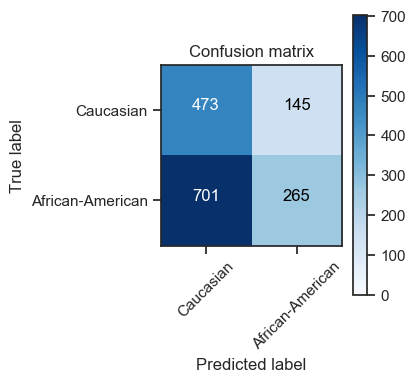

In [47]:
cnf_matrix = confusion_matrix(pd.get_dummies(prediction['race'])[0], Y_pred_debiassed[1][:,0] < 0.55)

np.set_printoptions(precision=2)

title="Confusion matrix"

# Plot normalized confusion matrix
fig = plt.figure(figsize=(4,4), dpi=100)
#fig.set_size_inches(6,6)

plot_confusion_matrix(cnf_matrix, classes=["Caucasian", "African-American"],normalize=False, 
                      title=title, cmap=plt.cm.Blues)

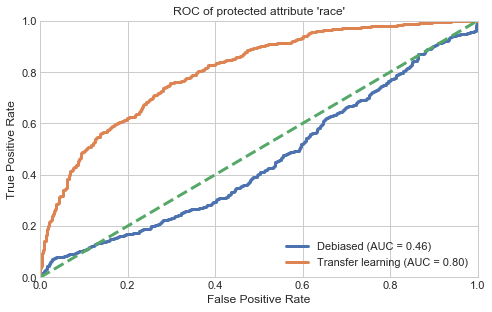

In [68]:
fig = plt.figure()
fig.set_size_inches(7,4.5)
plt.style.use('seaborn-whitegrid')
plt.title("ROC of protected attribute 'race'")

# debiased ROC
false_positive_rate, true_positive_rate, thresholds = roc_curve(pd.get_dummies(prediction['race'])[0], Y_pred_debiassed[1][:,0])
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate,
label='Debiased (AUC = %0.2f)'% roc_auc,  linewidth=3)

# Transfer learning ROC
false_positive_rate, true_positive_rate, thresholds = roc_curve(pd.get_dummies(prediction['race'])[0], Y_pred[:,0])
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate,
label='Transfer learning (AUC = %0.2f)'% roc_auc,  linewidth=3)

plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'--', linewidth=3)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.tight_layout()
plt.show()
#fig.savefig("roc_curve.png", dpi=300,  transparent=True)

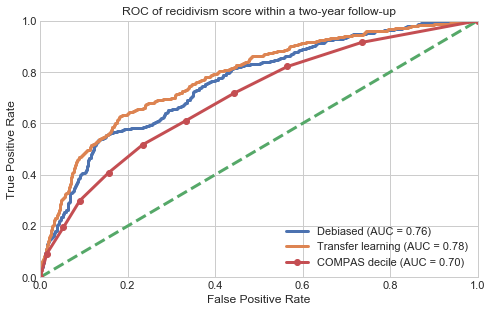

In [81]:
fig = plt.figure()
fig.set_size_inches(7,4.5)
plt.style.use('seaborn-whitegrid')
plt.title('ROC of recidivism score within a two-year follow-up')

# debiased ROC
false_positive_rate, true_positive_rate, thresholds = roc_curve(prediction['two_year_recid'], prediction['debiased_prediction'])
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate,
label='Debiased (AUC = %0.2f)'% roc_auc,  linewidth=3)

# Transfer learning ROC
false_positive_rate, true_positive_rate, thresholds = roc_curve(prediction['two_year_recid'], prediction['prediction'])
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate,
label='Transfer learning (AUC = %0.2f)'% roc_auc,  linewidth=3)

plt.plot([0,1],[0,1],'--', linewidth=3)

# COMPAS ROC
false_positive_rate, true_positive_rate, thresholds = roc_curve(prediction['two_year_recid'], prediction['true'])
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate, "-o",
label='COMPAS decile (AUC = %0.2f)'% roc_auc,  linewidth=3)

plt.legend(loc='lower right')


plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.tight_layout()
plt.show()
#fig.savefig("roc_curve.png", dpi=300,  transparent=True)

# References
<div class="csl-bib-body" style="line-height: 1.35; margin-left: 2em; text-indent:-2em;">
  <div class="csl-entry">Adel, Tameem, Isabel Valera, Zoubin Ghahramani, and Adrian Weller. 2019. “One-Network Adversarial Fairness.” In <i>AAAI</i>.</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Abook&amp;rft.genre=proceeding&amp;rft.atitle=One-Network%20Adversarial%20Fairness&amp;rft.btitle=AAAI&amp;rft.aufirst=Tameem&amp;rft.aulast=Adel&amp;rft.au=Tameem%20Adel&amp;rft.au=Isabel%20Valera&amp;rft.au=Zoubin%20Ghahramani&amp;rft.au=Adrian%20Weller&amp;rft.date=2019"></span>
  <div class="csl-entry">Ajakan, Hana, Pascal Germain, Hugo Larochelle, François Laviolette, and Mario Marchand. 2014. “Domain-Adversarial Neural Networks.” <i>ArXiv:1412.4446 [Cs, Stat]</i>, December. <a href="http://arxiv.org/abs/1412.4446">http://arxiv.org/abs/1412.4446</a>.</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Ajournal&amp;rft.genre=article&amp;rft.atitle=Domain-Adversarial%20Neural%20Networks&amp;rft.jtitle=arXiv%3A1412.4446%20%5Bcs%2C%20stat%5D&amp;rft.aufirst=Hana&amp;rft.aulast=Ajakan&amp;rft.au=Hana%20Ajakan&amp;rft.au=Pascal%20Germain&amp;rft.au=Hugo%20Larochelle&amp;rft.au=Fran%C3%A7ois%20Laviolette&amp;rft.au=Mario%20Marchand&amp;rft.date=2014-12-14"></span>
  <div class="csl-entry">Albright, Alex. n.d. “If You Give a Judge a Risk Score: Evidence from Kentucky Bail Decisions,” 40.</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Ajournal&amp;rft.genre=article&amp;rft.atitle=If%20You%20Give%20a%20Judge%20a%20Risk%20Score%3A%20Evidence%20from%20Kentucky%20Bail%20Decisions&amp;rft.aufirst=Alex&amp;rft.aulast=Albright&amp;rft.au=Alex%20Albright&amp;rft.pages=40&amp;rft.language=en"></span>
  <div class="csl-entry">Angwin, Julia, and Jeff Larson. 2016. “Machine Bias: There’s Software Used across the Country to Predict Future Criminals. and It’s Biased against Blacks.” Text/html. ProPublica. May 23, 2016. <a href="https://www.propublica.org/article/ machine-bias-risk-assessments-in-criminal-sentencing">https://www.propublica.org/article/ machine-bias-risk-assessments-in-criminal-sentencing</a>.</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Adc&amp;rft.type=webpage&amp;rft.title=Machine%20bias%3A%20There%E2%80%99s%20software%20used%20across%20the%20country%20to%20predict%20future%20criminals.%20and%20it%E2%80%99s%20biased%20against%20blacks.&amp;rft.rights=Copyright%20%C2%A92019%20ProPublica.&amp;rft.description=ProPublica%20is%20an%20independent%2C%20non-profit%20newsroom%20that%20produces%20investigative%20journalism%20in%20the%20public%20interest.&amp;rft.identifier=https%3A%2F%2Fwww.propublica.org%2Farticle%2F%20machine-bias-risk-assessments-in-criminal-sentencing&amp;rft.aufirst=Julia&amp;rft.aulast=Angwin&amp;rft.au=Julia%20Angwin&amp;rft.au=Jeff%20Larson&amp;rft.date=2016-05-23&amp;rft.language=en"></span>
  <div class="csl-entry">Antoniou, Antreas, Amos Storkey, and Harrison Edwards. 2017. “Data Augmentation Generative Adversarial Networks.” <i>ArXiv:1711.04340 [Cs, Stat]</i>, November. <a href="http://arxiv.org/abs/1711.04340">http://arxiv.org/abs/1711.04340</a>.</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Ajournal&amp;rft.genre=article&amp;rft.atitle=Data%20Augmentation%20Generative%20Adversarial%20Networks&amp;rft.jtitle=arXiv%3A1711.04340%20%5Bcs%2C%20stat%5D&amp;rft.aufirst=Antreas&amp;rft.aulast=Antoniou&amp;rft.au=Antreas%20Antoniou&amp;rft.au=Amos%20Storkey&amp;rft.au=Harrison%20Edwards&amp;rft.date=2017-11-12"></span>
  <div class="csl-entry">Baharlouei, Sina, Maher Nouiehed, and Meisam Razaviyayn. 2019. “Rényi Fair Inference.” <i>ArXiv</i> abs/1906.12005.</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Ajournal&amp;rft.genre=article&amp;rft.atitle=R%C3%A9nyi%20Fair%20Inference&amp;rft.jtitle=ArXiv&amp;rft.volume=abs%2F1906.12005&amp;rft.aufirst=Sina&amp;rft.aulast=Baharlouei&amp;rft.au=Sina%20Baharlouei&amp;rft.au=Maher%20Nouiehed&amp;rft.au=Meisam%20Razaviyayn&amp;rft.date=2019"></span>
  <div class="csl-entry">Barenstein, Matias. 2019. “ProPublica’s COMPAS Data Revisited.” <i>ArXiv:1906.04711 [Cs, Econ, q-Fin, Stat]</i>, June. <a href="http://arxiv.org/abs/1906.04711">http://arxiv.org/abs/1906.04711</a>.</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Ajournal&amp;rft.genre=article&amp;rft.atitle=ProPublica's%20COMPAS%20Data%20Revisited&amp;rft.jtitle=arXiv%3A1906.04711%20%5Bcs%2C%20econ%2C%20q-fin%2C%20stat%5D&amp;rft.aufirst=Matias&amp;rft.aulast=Barenstein&amp;rft.au=Matias%20Barenstein&amp;rft.date=2019-06-11"></span>
  <div class="csl-entry">Bellamy, Rachel K. E., Kuntal Dey, Michael Hind, Samuel C. Hoffman, Stephanie Houde, Kalapriya Kannan, Pranay Lohia, et al. 2018. “AI Fairness 360: An Extensible Toolkit for Detecting, Understanding, and Mitigating Unwanted Algorithmic Bias.” <i>ArXiv:1810.01943 [Cs]</i>, October. <a href="http://arxiv.org/abs/1810.01943">http://arxiv.org/abs/1810.01943</a>.</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Ajournal&amp;rft.genre=article&amp;rft.atitle=AI%20Fairness%20360%3A%20An%20Extensible%20Toolkit%20for%20Detecting%2C%20Understanding%2C%20and%20Mitigating%20Unwanted%20Algorithmic%20Bias&amp;rft.jtitle=arXiv%3A1810.01943%20%5Bcs%5D&amp;rft.aufirst=Rachel%20K.%20E.&amp;rft.aulast=Bellamy&amp;rft.au=Rachel%20K.%20E.%20Bellamy&amp;rft.au=Kuntal%20Dey&amp;rft.au=Michael%20Hind&amp;rft.au=Samuel%20C.%20Hoffman&amp;rft.au=Stephanie%20Houde&amp;rft.au=Kalapriya%20Kannan&amp;rft.au=Pranay%20Lohia&amp;rft.au=Jacquelyn%20Martino&amp;rft.au=Sameep%20Mehta&amp;rft.au=Aleksandra%20Mojsilovic&amp;rft.au=Seema%20Nagar&amp;rft.au=Karthikeyan%20Natesan%20Ramamurthy&amp;rft.au=John%20Richards&amp;rft.au=Diptikalyan%20Saha&amp;rft.au=Prasanna%20Sattigeri&amp;rft.au=Moninder%20Singh&amp;rft.au=Kush%20R.%20Varshney&amp;rft.au=Yunfeng%20Zhang&amp;rft.date=2018-10-03"></span>
  <div class="csl-entry">Chouldechova, Alexandra. 2017. “Fair Prediction with Disparate Impact: A Study of Bias in Recidivism Prediction Instruments.” <i>ArXiv:1703.00056 [Cs, Stat]</i>, February. <a href="http://arxiv.org/abs/1703.00056">http://arxiv.org/abs/1703.00056</a>.</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Ajournal&amp;rft.genre=article&amp;rft.atitle=Fair%20prediction%20with%20disparate%20impact%3A%20A%20study%20of%20bias%20in%20recidivism%20prediction%20instruments&amp;rft.jtitle=arXiv%3A1703.00056%20%5Bcs%2C%20stat%5D&amp;rft.aufirst=Alexandra&amp;rft.aulast=Chouldechova&amp;rft.au=Alexandra%20Chouldechova&amp;rft.date=2017-02-28"></span>
  <div class="csl-entry">Dieterich, William, Christina Mendoza, and Tim Brennan. 2016. “COMPAS Risk Scales: Demonstrating Accuracy Equity and Predictive Parity.” <a href="http://go.volarisgroup.com/rs/430-MBX-989/images/ProPublica_Commentary_Final_070616.pdf">http://go.volarisgroup.com/rs/430-MBX-989/images/ProPublica_Commentary_Final_070616.pdf</a>.</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Adc&amp;rft.type=document&amp;rft.title=COMPAS%20Risk%20Scales%3A%20Demonstrating%20Accuracy%20Equity%20and%20Predictive%20Parity&amp;rft.description=This%20research%20report%20presents%20Northpointe%E2%80%99s%20technical%20analysis%20of%20the%20Broward%20County%20data%20that%20was%20used%20in%20ProPublica%E2%80%99s%20article%20%E2%80%9CMachine%20Bias%E2%80%9D%20published%20by%20ProPublica%20on%20May%2023%2C%202016%20(Angwin%2C%20Larson%2C%20Mattu%2C%20%26%20Kirchner%2C%202016).%0AWe%20carefully%20examined%20the%20statistical%20methods%20in%20the%20article%20and%20conducted%20our%20own%20thorough%20analysis%20of%20the%20data%20that%20the%20ProPublica%20authors%20used%20for%20their%20study%20and%20made%20available%20through%20their%20web%20site.%0ABased%20on%20our%20examination%20of%20the%20work%20of%20Angwin%20et%20al.%20and%20on%20results%20of%20our%20analysis%20of%20their%20data%2C%20we%20strongly%20reject%20the%20conclusion%20that%20the%20COMPAS%20risk%20scales%20are%20racially%20biased%20against%20blacks.%20This%20report%20presents%20evidence%20that%20refutes%20the%20claim%20that%20the%20COMPAS%20risk%20scales%20were%20biased%20against%20black%20defendants%20in%20a%20sample%20of%20pretrial%20defendants%20in%20Broward%20County%2C%20Florida.%0AOur%20review%20leads%20us%20to%20believe%20that%20ProPublica%20made%20several%20statistical%20and%20technical%20errors%20such%20as%20misspecified%20regression%20models%2C%20wrongly%20defined%20classi-%20fication%20terms%20and%20measures%20of%20discrimination%2C%20and%20the%20incorrect%20interpretation%20and%20use%20of%20model%20errors.%0A%F4%8F%B0%80%20ProPublica%20focused%20on%20classification%20statistics%20that%20did%20not%20take%20into%20ac-%20count%20the%20different%20base%20rates%20of%20recidivism%20for%20blacks%20and%20whites.%20Their%20use%20of%20these%20statistics%20resulted%20in%20false%20assertions%20in%20their%20article%20that%20were%20repeated%20subsequently%20in%20interviews%20and%20in%20articles%20in%20the%20national%20media.%0A%F4%8F%B0%80%20When%20the%20correct%20classification%20statistics%20are%20used%2C%20the%20data%20do%20not%20sub-%20stantiate%20the%20ProPublica%20claim%20of%20racial%20bias%20towards%20blacks.%0A%F4%8F%B0%80%20The%20proper%20interpretation%20of%20the%20results%20in%20the%20samples%20used%20by%20ProPub-%20lica%20demonstrates%20that%20the%20General%20Recidivism%20Risk%20Scale%20(GRRS)%20and%20Violent%20Recidivism%20Risk%20Scale%20(VRRS)%20are%20equally%20accurate%20for%20blacks%20and%20whites.&amp;rft.identifier=http%3A%2F%2Fgo.volarisgroup.com%2Frs%2F430-MBX-989%2Fimages%2FProPublica_Commentary_Final_070616.pdf&amp;rft.aufirst=William&amp;rft.aulast=Dieterich&amp;rft.au=William%20Dieterich&amp;rft.au=Christina%20Mendoza&amp;rft.au=Tim%20Brennan&amp;rft.date=2016"></span>
  <div class="csl-entry">Dixon, Lucas, John Li, Jeffrey Sorensen, Nithum Thain, and Lucy Vasserman. 2018. “Measuring and Mitigating Unintended Bias in Text Classification.” In <i>Proceedings of the 2018 AAAI/ACM Conference on AI, Ethics, and Society&nbsp; - AIES ’18</i>, 67–73. New Orleans, LA, USA: ACM Press. <a href="https://doi.org/10.1145/3278721.3278729">https://doi.org/10.1145/3278721.3278729</a>.</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_id=info%3Adoi%2F10.1145%2F3278721.3278729&amp;rft_id=urn%3Aisbn%3A978-1-4503-6012-8&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Abook&amp;rft.genre=proceeding&amp;rft.atitle=Measuring%20and%20Mitigating%20Unintended%20Bias%20in%20Text%20Classification&amp;rft.btitle=Proceedings%20of%20the%202018%20AAAI%2FACM%20Conference%20on%20AI%2C%20Ethics%2C%20and%20Society%20%20-%20AIES%20'18&amp;rft.place=New%20Orleans%2C%20LA%2C%20USA&amp;rft.publisher=ACM%20Press&amp;rft.aufirst=Lucas&amp;rft.aulast=Dixon&amp;rft.au=Lucas%20Dixon&amp;rft.au=John%20Li&amp;rft.au=Jeffrey%20Sorensen&amp;rft.au=Nithum%20Thain&amp;rft.au=Lucy%20Vasserman&amp;rft.date=2018&amp;rft.pages=67-73&amp;rft.spage=67&amp;rft.epage=73&amp;rft.isbn=978-1-4503-6012-8&amp;rft.language=en"></span>
  <div class="csl-entry">Dua, Dheeru, and Casey Graff. 2017. “UCI Machine Learning Repository.” <a href="http://archive.ics.uci.edu/ml">http://archive.ics.uci.edu/ml</a>.</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Ajournal&amp;rft.genre=article&amp;rft.atitle=UCI%20machine%20learning%20repository&amp;rft.aufirst=Dheeru&amp;rft.aulast=Dua&amp;rft.au=Dheeru%20Dua&amp;rft.au=Casey%20Graff&amp;rft.date=2017"></span>
  <div class="csl-entry">Dwork, Cynthia, Moritz Hardt, Toniann Pitassi, Omer Reingold, and Richard Zemel. 2012. “Fairness Through Awareness.” In <i>Proceedings of the 3rd Innovations in Theoretical Computer Science Conference</i>, 214–226. ITCS ’12. New York, NY, USA: ACM. <a href="https://doi.org/10.1145/2090236.2090255">https://doi.org/10.1145/2090236.2090255</a>.</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_id=info%3Adoi%2F10.1145%2F2090236.2090255&amp;rft_id=urn%3Aisbn%3A978-1-4503-1115-1&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Abook&amp;rft.genre=proceeding&amp;rft.atitle=Fairness%20Through%20Awareness&amp;rft.btitle=Proceedings%20of%20the%203rd%20Innovations%20in%20Theoretical%20Computer%20Science%20Conference&amp;rft.place=New%20York%2C%20NY%2C%20USA&amp;rft.publisher=ACM&amp;rft.series=ITCS%20'12&amp;rft.aufirst=Cynthia&amp;rft.aulast=Dwork&amp;rft.au=Cynthia%20Dwork&amp;rft.au=Moritz%20Hardt&amp;rft.au=Toniann%20Pitassi&amp;rft.au=Omer%20Reingold&amp;rft.au=Richard%20Zemel&amp;rft.date=2012&amp;rft.pages=214%E2%80%93226&amp;rft.spage=214&amp;rft.epage=226&amp;rft.isbn=978-1-4503-1115-1"></span>
  <div class="csl-entry">Edwards, Harrison, and Amos Storkey. 2015. “Censoring Representations with an Adversary.” <i>ArXiv:1511.05897 [Cs, Stat]</i>, November. <a href="http://arxiv.org/abs/1511.05897">http://arxiv.org/abs/1511.05897</a>.</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Ajournal&amp;rft.genre=article&amp;rft.atitle=Censoring%20Representations%20with%20an%20Adversary&amp;rft.jtitle=arXiv%3A1511.05897%20%5Bcs%2C%20stat%5D&amp;rft.aufirst=Harrison&amp;rft.aulast=Edwards&amp;rft.au=Harrison%20Edwards&amp;rft.au=Amos%20Storkey&amp;rft.date=2015-11-18"></span>
  <div class="csl-entry">Feldman, Michael, Sorelle A Friedler, John Moeller, Carlos Scheidegger, and Suresh Venkatasubramanian. 2015. “Certifying and Removing Disparate Impact.” In <i>Proceedings of the 21th ACM SIGKDD International Conference on Knowledge Discovery and Data Mining</i>, 259–68.</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Abook&amp;rft.genre=proceeding&amp;rft.atitle=Certifying%20and%20removing%20disparate%20impact&amp;rft.btitle=Proceedings%20of%20the%2021th%20ACM%20SIGKDD%20International%20Conference%20on%20Knowledge%20Discovery%20and%20Data%20Mining&amp;rft.aufirst=Michael&amp;rft.aulast=Feldman&amp;rft.au=Michael%20Feldman&amp;rft.au=Sorelle%20A%20Friedler&amp;rft.au=John%20Moeller&amp;rft.au=Carlos%20Scheidegger&amp;rft.au=Suresh%20Venkatasubramanian&amp;rft.date=2015&amp;rft.pages=259-268&amp;rft.spage=259&amp;rft.epage=268"></span>
  <div class="csl-entry">Ganin, Yaroslav, Evgeniya Ustinova, Hana Ajakan, Pascal Germain, Hugo Larochelle, François Laviolette, Mario Marchand, and Victor Lempitsky. 2017. “Domain-Adversarial Training of Neural Networks.” In <i>Domain Adaptation in Computer Vision Applications</i>, edited by Gabriela Csurka, 189–209. Cham: Springer International Publishing. <a href="https://doi.org/10.1007/978-3-319-58347-1_10">https://doi.org/10.1007/978-3-319-58347-1_10</a>.</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_id=urn%3Aisbn%3A978-3-319-58346-4%20978-3-319-58347-1&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Abook&amp;rft.genre=bookitem&amp;rft.atitle=Domain-Adversarial%20Training%20of%20Neural%20Networks&amp;rft.place=Cham&amp;rft.publisher=Springer%20International%20Publishing&amp;rft.aufirst=Yaroslav&amp;rft.aulast=Ganin&amp;rft.au=Gabriela%20Csurka&amp;rft.au=Yaroslav%20Ganin&amp;rft.au=Evgeniya%20Ustinova&amp;rft.au=Hana%20Ajakan&amp;rft.au=Pascal%20Germain&amp;rft.au=Hugo%20Larochelle&amp;rft.au=Fran%C3%A7ois%20Laviolette&amp;rft.au=Mario%20Marchand&amp;rft.au=Victor%20Lempitsky&amp;rft.date=2017&amp;rft.pages=189-209&amp;rft.spage=189&amp;rft.epage=209&amp;rft.isbn=978-3-319-58346-4%20978-3-319-58347-1&amp;rft.language=en"></span>
  <div class="csl-entry">Goodfellow, Ian J., Jonathon Shlens, and Christian Szegedy. 2014. “Explaining and Harnessing Adversarial Examples.” <i>ArXiv:1412.6572 [Cs, Stat]</i>, December. <a href="http://arxiv.org/abs/1412.6572">http://arxiv.org/abs/1412.6572</a>.</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Ajournal&amp;rft.genre=article&amp;rft.atitle=Explaining%20and%20Harnessing%20Adversarial%20Examples&amp;rft.jtitle=arXiv%3A1412.6572%20%5Bcs%2C%20stat%5D&amp;rft.aufirst=Ian%20J.&amp;rft.aulast=Goodfellow&amp;rft.au=Ian%20J.%20Goodfellow&amp;rft.au=Jonathon%20Shlens&amp;rft.au=Christian%20Szegedy&amp;rft.date=2014-12-19"></span>
  <div class="csl-entry">Goodfellow, Ian, Jean Pouget-Abadie, Mehdi Mirza, Bing Xu, David Warde-Farley, Sherjil Ozair, Aaron Courville, and Yoshua Bengio. 2014. “Generative Adversarial Nets.” In <i>Advances in Neural Information Processing Systems 27</i>, edited by Z. Ghahramani, M. Welling, C. Cortes, N. D. Lawrence, and K. Q. Weinberger, 2672–2680. Curran Associates, Inc. <a href="http://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf">http://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf</a>.</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Abook&amp;rft.genre=bookitem&amp;rft.atitle=Generative%20Adversarial%20Nets&amp;rft.publisher=Curran%20Associates%2C%20Inc.&amp;rft.aufirst=Ian&amp;rft.aulast=Goodfellow&amp;rft.au=Ian%20Goodfellow&amp;rft.au=Jean%20Pouget-Abadie&amp;rft.au=Mehdi%20Mirza&amp;rft.au=Bing%20Xu&amp;rft.au=David%20Warde-Farley&amp;rft.au=Sherjil%20Ozair&amp;rft.au=Aaron%20Courville&amp;rft.au=Yoshua%20Bengio&amp;rft.au=Z.%20Ghahramani&amp;rft.au=M.%20Welling&amp;rft.au=C.%20Cortes&amp;rft.au=N.%20D.%20Lawrence&amp;rft.au=K.%20Q.%20Weinberger&amp;rft.date=2014&amp;rft.pages=2672%E2%80%932680&amp;rft.spage=2672&amp;rft.epage=2680"></span>
  <div class="csl-entry">Gürses, Seda, Rebekah Overdorf, and Ero Balsa. n.d. “POTs: The Revolution Will Not Be Optimized?,” 2.</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Ajournal&amp;rft.genre=article&amp;rft.atitle=POTs%3A%20the%20revolution%20will%20not%20be%20optimized%3F&amp;rft.aufirst=Seda&amp;rft.aulast=G%C3%BCrses&amp;rft.au=Seda%20G%C3%BCrses&amp;rft.au=Rebekah%20Overdorf&amp;rft.au=Ero%20Balsa&amp;rft.pages=2&amp;rft.language=en"></span>
  <div class="csl-entry">Hardt, Moritz, Eric Price, ecprice, and Nati Srebro. 2016. “Equality of Opportunity in Supervised Learning.” In <i>Advances in Neural Information Processing Systems 29</i>, edited by D. D. Lee, M. Sugiyama, U. V. Luxburg, I. Guyon, and R. Garnett, 3315–3323. Curran Associates, Inc. <a href="http://papers.nips.cc/paper/6374-equality-of-opportunity-in-supervised-learning.pdf">http://papers.nips.cc/paper/6374-equality-of-opportunity-in-supervised-learning.pdf</a>.</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Abook&amp;rft.genre=bookitem&amp;rft.atitle=Equality%20of%20Opportunity%20in%20Supervised%20Learning&amp;rft.publisher=Curran%20Associates%2C%20Inc.&amp;rft.aufirst=Moritz&amp;rft.aulast=Hardt&amp;rft.au=Moritz%20Hardt&amp;rft.au=Eric%20Price&amp;rft.au=undefined&amp;rft.au=Nati%20Srebro&amp;rft.au=D.%20D.%20Lee&amp;rft.au=M.%20Sugiyama&amp;rft.au=U.%20V.%20Luxburg&amp;rft.au=I.%20Guyon&amp;rft.au=R.%20Garnett&amp;rft.date=2016&amp;rft.pages=3315%E2%80%933323&amp;rft.spage=3315&amp;rft.epage=3323"></span>
  <div class="csl-entry">Liu, Frederick, and Besim Avci. 2019. “Incorporating Priors with Feature Attribution on Text Classification.” In <i>ACL</i>.</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Abook&amp;rft.genre=proceeding&amp;rft.atitle=Incorporating%20Priors%20with%20Feature%20Attribution%20on%20Text%20Classification&amp;rft.btitle=ACL&amp;rft.aufirst=Frederick&amp;rft.aulast=Liu&amp;rft.au=Frederick%20Liu&amp;rft.au=Besim%20Avci&amp;rft.date=2019"></span>
  <div class="csl-entry">Louizos, Christos, Kevin Swersky, Yujia Li, Max Welling, and Richard Zemel. 2015. “The Variational Fair Autoencoder.” <i>ArXiv:1511.00830 [Cs, Stat]</i>, November. <a href="http://arxiv.org/abs/1511.00830">http://arxiv.org/abs/1511.00830</a>.</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Ajournal&amp;rft.genre=article&amp;rft.atitle=The%20Variational%20Fair%20Autoencoder&amp;rft.jtitle=arXiv%3A1511.00830%20%5Bcs%2C%20stat%5D&amp;rft.aufirst=Christos&amp;rft.aulast=Louizos&amp;rft.au=Christos%20Louizos&amp;rft.au=Kevin%20Swersky&amp;rft.au=Yujia%20Li&amp;rft.au=Max%20Welling&amp;rft.au=Richard%20Zemel&amp;rft.date=2015-11-03"></span>
  <div class="csl-entry">Luong, Binh Thanh, Salvatore Ruggieri, and Franco Turini. 2011. “K-NN as an Implementation of Situation Testing for Discrimination Discovery and Prevention.” In <i>Proceedings of the 17th ACM SIGKDD International Conference on Knowledge Discovery and Data Mining - KDD ’11</i>, 502. San Diego, California, USA: ACM Press. <a href="https://doi.org/10.1145/2020408.2020488">https://doi.org/10.1145/2020408.2020488</a>.</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_id=info%3Adoi%2F10.1145%2F2020408.2020488&amp;rft_id=urn%3Aisbn%3A978-1-4503-0813-7&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Abook&amp;rft.genre=proceeding&amp;rft.atitle=k-NN%20as%20an%20implementation%20of%20situation%20testing%20for%20discrimination%20discovery%20and%20prevention&amp;rft.btitle=Proceedings%20of%20the%2017th%20ACM%20SIGKDD%20international%20conference%20on%20Knowledge%20discovery%20and%20data%20mining%20-%20KDD%20'11&amp;rft.place=San%20Diego%2C%20California%2C%20USA&amp;rft.publisher=ACM%20Press&amp;rft.aufirst=Binh%20Thanh&amp;rft.aulast=Luong&amp;rft.au=Binh%20Thanh%20Luong&amp;rft.au=Salvatore%20Ruggieri&amp;rft.au=Franco%20Turini&amp;rft.date=2011&amp;rft.pages=502&amp;rft.isbn=978-1-4503-0813-7&amp;rft.language=en"></span>
  <div class="csl-entry">Madras, David, Elliot Creager, Toniann Pitassi, and Richard S. Zemel. 2018. “Learning Adversarially Fair and Transferable Representations.” <i>ArXiv</i> abs/1802.06309.</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Ajournal&amp;rft.genre=article&amp;rft.atitle=Learning%20Adversarially%20Fair%20and%20Transferable%20Representations&amp;rft.jtitle=ArXiv&amp;rft.volume=abs%2F1802.06309&amp;rft.aufirst=David&amp;rft.aulast=Madras&amp;rft.au=David%20Madras&amp;rft.au=Elliot%20Creager&amp;rft.au=Toniann%20Pitassi&amp;rft.au=Richard%20S.%20Zemel&amp;rft.date=2018"></span>
  <div class="csl-entry">Northpointe. 2015. “Practitioners Guide to COMPAS.”</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Adc&amp;rft.type=document&amp;rft.title=Practitioners%20Guide%20to%20COMPAS&amp;rft.au=undefined&amp;rft.date=2015"></span>
  <div class="csl-entry">Overdorf, Rebekah, Bogdan Kulynych, Ero Balsa, Carmela Troncoso, and Seda Gürses. 2018a. “POTs: Protective Optimization Technologies.” <i>ArXiv:1806.02711 [Cs]</i>, June. <a href="http://arxiv.org/abs/1806.02711">http://arxiv.org/abs/1806.02711</a>.</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Ajournal&amp;rft.genre=article&amp;rft.atitle=POTs%3A%20Protective%20Optimization%20Technologies&amp;rft.jtitle=arXiv%3A1806.02711%20%5Bcs%5D&amp;rft.aufirst=Rebekah&amp;rft.aulast=Overdorf&amp;rft.au=Rebekah%20Overdorf&amp;rft.au=Bogdan%20Kulynych&amp;rft.au=Ero%20Balsa&amp;rft.au=Carmela%20Troncoso&amp;rft.au=Seda%20G%C3%BCrses&amp;rft.date=2018-06-07"></span>
  <div class="csl-entry">———. 2018b. “Questioning the Assumptions behind Fairness Solutions.” <i>ArXiv:1811.11293 [Cs]</i>, November. <a href="http://arxiv.org/abs/1811.11293">http://arxiv.org/abs/1811.11293</a>.</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Ajournal&amp;rft.genre=article&amp;rft.atitle=Questioning%20the%20assumptions%20behind%20fairness%20solutions&amp;rft.jtitle=arXiv%3A1811.11293%20%5Bcs%5D&amp;rft.aufirst=Rebekah&amp;rft.aulast=Overdorf&amp;rft.au=Rebekah%20Overdorf&amp;rft.au=Bogdan%20Kulynych&amp;rft.au=Ero%20Balsa&amp;rft.au=Carmela%20Troncoso&amp;rft.au=Seda%20G%C3%BCrses&amp;rft.date=2018-11-27"></span>
  <div class="csl-entry">Raff, E., and J. Sylvester. 2018. “Gradient Reversal against Discrimination: A Fair Neural Network Learning Approach.” In <i>2018 IEEE 5th International Conference on Data Science and Advanced Analytics (DSAA)</i>, 189–98. <a href="https://doi.org/10.1109/DSAA.2018.00029">https://doi.org/10.1109/DSAA.2018.00029</a>.</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_id=info%3Adoi%2F10.1109%2FDSAA.2018.00029&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Abook&amp;rft.genre=proceeding&amp;rft.atitle=Gradient%20Reversal%20against%20Discrimination%3A%20A%20Fair%20Neural%20Network%20Learning%20Approach&amp;rft.btitle=2018%20IEEE%205th%20International%20Conference%20on%20Data%20Science%20and%20Advanced%20Analytics%20(DSAA)&amp;rft.aufirst=E.&amp;rft.aulast=Raff&amp;rft.au=E.%20Raff&amp;rft.au=J.%20Sylvester&amp;rft.date=2018-10&amp;rft.pages=189-198&amp;rft.spage=189&amp;rft.epage=198"></span>
  <div class="csl-entry">Romei, Andrea, and Salvatore Ruggieri. 2014. “A Multidisciplinary Survey on Discrimination Analysis.” <i>The Knowledge Engineering Review</i> 29 (5): 582–638. <a href="https://doi.org/10.1017/S0269888913000039">https://doi.org/10.1017/S0269888913000039</a>.</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_id=info%3Adoi%2F10.1017%2FS0269888913000039&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Ajournal&amp;rft.genre=article&amp;rft.atitle=A%20multidisciplinary%20survey%20on%20discrimination%20analysis&amp;rft.jtitle=The%20Knowledge%20Engineering%20Review&amp;rft.stitle=The%20Knowledge%20Engineering%20Review&amp;rft.volume=29&amp;rft.issue=5&amp;rft.aufirst=Andrea&amp;rft.aulast=Romei&amp;rft.au=Andrea%20Romei&amp;rft.au=Salvatore%20Ruggieri&amp;rft.date=2014-11&amp;rft.pages=582-638&amp;rft.spage=582&amp;rft.epage=638&amp;rft.issn=0269-8889%2C%201469-8005&amp;rft.language=en"></span>
  <div class="csl-entry">Sattigeri, Prasanna, Samuel C Hoffman, Vijil Chenthamarakshan, and Kush R Varshney. 2019. “Fairness GAN: Generating Datasets With Fairness Properties Using a Generative Adversarial Network,” 12.</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Ajournal&amp;rft.genre=article&amp;rft.atitle=Fairness%20GAN%3A%20Generating%20Datasets%20With%20Fairness%20Properties%20Using%20a%20Generative%20Adversarial%20Network&amp;rft.aufirst=Prasanna&amp;rft.aulast=Sattigeri&amp;rft.au=Prasanna%20Sattigeri&amp;rft.au=Samuel%20C%20Hoffman&amp;rft.au=Vijil%20Chenthamarakshan&amp;rft.au=Kush%20R%20Varshney&amp;rft.date=2019&amp;rft.pages=12&amp;rft.language=en"></span>
  <div class="csl-entry">Singh, Jay P., Daryl G. Kroner, J. Stephen Wormith, Sarah L. Desmarais, and Zachary Hamilton. 2018. <i>Handbook of Recidivism Risk / Needs Assessment Tools</i>. John Wiley &amp; Sons.</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_id=urn%3Aisbn%3A978-1-119-18428-7&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Abook&amp;rft.genre=book&amp;rft.btitle=Handbook%20of%20Recidivism%20Risk%20%2F%20Needs%20Assessment%20Tools&amp;rft.publisher=John%20Wiley%20%26%20Sons&amp;rft.aufirst=Jay%20P.&amp;rft.aulast=Singh&amp;rft.au=Jay%20P.%20Singh&amp;rft.au=Daryl%20G.%20Kroner&amp;rft.au=J.%20Stephen%20Wormith&amp;rft.au=Sarah%20L.%20Desmarais&amp;rft.au=Zachary%20Hamilton&amp;rft.date=2018-02-05&amp;rft.tpages=346&amp;rft.isbn=978-1-119-18428-7&amp;rft.language=en"></span>
  <div class="csl-entry">Zehlike, Meike, Carlos Castillo, Francesco Bonchi, Ricardo Baeza-Yates, Sara Hajian, and Mohamed Megahed. 2017. “FAIRNESS MEASURES: A Platform for Data Collection and Benchmarking in Discrimination-Aware ML,” June. <a href="http://fairness-measures.org">http://fairness-measures.org</a>.</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Ajournal&amp;rft.genre=article&amp;rft.atitle=%22FAIRNESS%20MEASURES%3A%20A%20platform%20for%20data%20collection%20and%20benchmarking%20in%20discrimination-aware%20ML%22&amp;rft.aufirst=Meike&amp;rft.aulast=Zehlike&amp;rft.au=Meike%20Zehlike&amp;rft.au=Carlos%20Castillo&amp;rft.au=Francesco%20Bonchi&amp;rft.au=Ricardo%20Baeza-Yates&amp;rft.au=Sara%20Hajian&amp;rft.au=Mohamed%20Megahed&amp;rft.date=2017-06"></span>
  <div class="csl-entry">Zemel, Rich, Yu Wu, Kevin Swersky, Toni Pitassi, and Cynthia Dwork. 2013. “Learning Fair Representations.” In <i>International Conference on Machine Learning</i>, 325–33.</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Abook&amp;rft.genre=proceeding&amp;rft.atitle=Learning%20fair%20representations&amp;rft.btitle=International%20Conference%20on%20Machine%20Learning&amp;rft.aufirst=Rich&amp;rft.aulast=Zemel&amp;rft.au=Rich%20Zemel&amp;rft.au=Yu%20Wu&amp;rft.au=Kevin%20Swersky&amp;rft.au=Toni%20Pitassi&amp;rft.au=Cynthia%20Dwork&amp;rft.date=2013&amp;rft.pages=325-333&amp;rft.spage=325&amp;rft.epage=333"></span>
  <div class="csl-entry">Zhang, Brian Hu, Blake Lemoine, and Margaret Mitchell. 2018. “Mitigating Unwanted Biases with Adversarial Learning.” In <i>Proceedings of the 2018 AAAI/ACM Conference on AI, Ethics, and Society&nbsp; - AIES ’18</i>, 335–40. New Orleans, LA, USA: ACM Press. <a href="https://doi.org/10.1145/3278721.3278779">https://doi.org/10.1145/3278721.3278779</a>.</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_id=info%3Adoi%2F10.1145%2F3278721.3278779&amp;rft_id=urn%3Aisbn%3A978-1-4503-6012-8&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Abook&amp;rft.genre=proceeding&amp;rft.atitle=Mitigating%20Unwanted%20Biases%20with%20Adversarial%20Learning&amp;rft.btitle=Proceedings%20of%20the%202018%20AAAI%2FACM%20Conference%20on%20AI%2C%20Ethics%2C%20and%20Society%20%20-%20AIES%20'18&amp;rft.place=New%20Orleans%2C%20LA%2C%20USA&amp;rft.publisher=ACM%20Press&amp;rft.aufirst=Brian%20Hu&amp;rft.aulast=Zhang&amp;rft.au=Brian%20Hu%20Zhang&amp;rft.au=Blake%20Lemoine&amp;rft.au=Margaret%20Mitchell&amp;rft.date=2018&amp;rft.pages=335-340&amp;rft.spage=335&amp;rft.epage=340&amp;rft.isbn=978-1-4503-6012-8&amp;rft.language=en"></span>
  <div class="csl-entry">Zhang, Lu, Yongkai Wu, and Xintao Wu. n.d. “Situation Testing-Based Discrimination Discovery: A Causal Inference Approach,” 7.</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Ajournal&amp;rft.genre=article&amp;rft.atitle=Situation%20Testing-Based%20Discrimination%20Discovery%3A%20A%20Causal%20Inference%20Approach&amp;rft.aufirst=Lu&amp;rft.aulast=Zhang&amp;rft.au=Lu%20Zhang&amp;rft.au=Yongkai%20Wu&amp;rft.au=Xintao%20Wu&amp;rft.pages=7&amp;rft.language=en"></span>
  <div class="csl-entry">Zhao, Han, and Geoffrey J. Gordon. 2019. “Inherent Tradeoffs in Learning Fair Representation.” <i>ArXiv:1906.08386 [Cs, Stat]</i>, June. <a href="http://arxiv.org/abs/1906.08386">http://arxiv.org/abs/1906.08386</a>.</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Ajournal&amp;rft.genre=article&amp;rft.atitle=Inherent%20Tradeoffs%20in%20Learning%20Fair%20Representation&amp;rft.jtitle=arXiv%3A1906.08386%20%5Bcs%2C%20stat%5D&amp;rft.aufirst=Han&amp;rft.aulast=Zhao&amp;rft.au=Han%20Zhao&amp;rft.au=Geoffrey%20J.%20Gordon&amp;rft.date=2019-06-19"></span>
  <div class="csl-entry">Žliobaitė, Indrė. 2017. “Measuring Discrimination in Algorithmic Decision Making.” <i>Data Mining and Knowledge Discovery</i> 31 (4): 1060–89. <a href="https://doi.org/10.1007/s10618-017-0506-1">https://doi.org/10.1007/s10618-017-0506-1</a>.</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_id=info%3Adoi%2F10.1007%2Fs10618-017-0506-1&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Ajournal&amp;rft.genre=article&amp;rft.atitle=Measuring%20discrimination%20in%20algorithmic%20decision%20making&amp;rft.jtitle=Data%20Mining%20and%20Knowledge%20Discovery&amp;rft.stitle=Data%20Min%20Knowl%20Disc&amp;rft.volume=31&amp;rft.issue=4&amp;rft.aufirst=Indr%C4%97&amp;rft.aulast=%C5%BDliobait%C4%97&amp;rft.au=Indr%C4%97%20%C5%BDliobait%C4%97&amp;rft.date=2017-07&amp;rft.pages=1060-1089&amp;rft.spage=1060&amp;rft.epage=1089&amp;rft.issn=1384-5810%2C%201573-756X&amp;rft.language=en"></span>
</div>

In [54]:
np.sqrt(np.mean(np.power(prediction['true'] - prediction['dec_pred'], 2)))

2.254904867083301

In [55]:
np.sqrt(np.mean(np.power(prediction['true'] - prediction['debiased_prediction'], 2)))

2.1466146267674744